# Text/Meeting Summarization

There are broadly two different approaches that are used for text summarization:

### Extractive Summarization   
We identify the important sentences or phrases from the original text and extract only those from the text. Those extracted sentences would be our summary. Some of the methods are:
1. Sentence Scoring based on Word Frequency
2. TextRank using Universal Sentence Encoder

### Abstractive Summarization    
Here, we generate new sentences from the original text. This is in contrast to the extractive approach we saw earlier where we used only the sentences that were present. The sentences generated through abstractive summarization might not be present in the original text:


In [1]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)
import collections
import re
import nltk
!pip install tika
import tika
import glob
tika.initVM()
import seaborn as sns
from tika import parser
from nltk.stem import SnowballStemmer
import os
import pandas as pd
import gensim, nltk, os
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import gensim
from gensim import corpora
import pickle
import random
from gensim import corpora, models
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
import spacy
import spacy.lang.en.stop_words as STOP_WORDS
from string import punctuation
from heapq import nlargest
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
import math

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sapnasharma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sapnasharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Do as follows if guidedlda in not getting installed with pip

from command window

git clone https://github.com/vi3k6i5/GuidedLDA
cd GuidedLDA
ls
sh build_dist.sh
python setup.py sdist
pip3 install -e .

pip3 install -U cython

remove the following 2 lines from setup.cfg:

[sdist]
pre-hook.sdist_pre_hook = guidedlda._setup_hooks.sdist_pre_hook




## Preprocessing
#### 1. Removing stop words
#### 2. lemmatising

In [2]:
'''
pre processing steps on the entire dataset
'''
# importing customized stopwords from customized_stopwords.txt

with open ('customized_stopwords', 'rb') as fp:
    customized_stopwords = pickle.load(fp)
more_stop_words = ['sounds','works','thinking','talking','dream','honestly','sofia','francis','simon','presently','month','wanna','longer','alternatively','hear','issue','options','difference','wouldn','morning','current','worry','short','school','plan','guest','bring','depend','latest','mention','earlier','read','simple','spend','include','friend','question','couldn','option','happen','finish','start','tomorrow','work','agree','think','middle','dicide','write','haven','understand','print','call','return','talk','happen']   
customized_stopwords=more_stop_words + customized_stopwords  
#stemmer = SnowballStemmer("english")
def lemmatize(word):                                    # input is a word that is to be converted to root word for verb
    return WordNetLemmatizer().lemmatize(word, pos = 'v')

def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if (token not in gensim.parsing.preprocessing.STOPWORDS) and (len(token) > 4) and (token not in customized_stopwords):
            token = lemmatize(token)
            if token not in customized_stopwords:
                result.append(lemmatize(token))
                
    return result

In [3]:
'''
Removing only stopwords(no lemmatisation)
'''
# importing customized stopwords from customized_stopwords.txt
with open ('customized_stopwords', 'rb') as fp:
    customized_stopwords = pickle.load(fp)
more_stop_words = ['sounds','works','thinking','talking','dream','honestly','sofia','francis','simon','presently','month','wanna','longer','alternatively','hear','issue','options','difference','wouldn','morning','current','worry','short','school','plan','guest','bring','depend','latest','mention','earlier','read','simple','spend','include','friend','question','couldn','option','happen','finish','start','tomorrow','work','agree','think','middle','dicide','write','haven','understand','print','call','return','talk','happen']   
customized_stopwords=more_stop_words + customized_stopwords  


def preprocess_stopwords(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if (token not in gensim.parsing.preprocessing.STOPWORDS) and (len(token) > 4) and (token not in customized_stopwords):
            #token = lemmatize(token)
            if token not in customized_stopwords:
                result.append((token))
                
    return result

In [4]:
# Word cloud of a meeting
def get_word_cloud(combined_words):
    #combined_words
    cleaned_combined_words = []
    for word in combined_words.split(" "):
        cleaned_combined_words += preprocess(word)
    cleaned_combined_words = " ".join(cleaned_combined_words)
    
    wordcloud = WordCloud(width=700, height=300, random_state=21, max_font_size=110).generate(cleaned_combined_words)
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title("Some frequent words used in the headlines", weight='bold', fontsize=14)
    plt.show()

## Sentence scoring based on word frequency(Spacy)

In [5]:
def get_spacy_summary(text,percent=.02):
    '''
    input : text -> text to be summarized, 
            percent -> ratio to which summary is needed
    returns : summary of text
    '''

    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    word_frequency = collections.Counter(preprocess_stopwords(text)) # word frequency dictionary
    
    max_frequency = max(word_frequency.values())

    for word in word_frequency.keys():
        word_frequency[word] =word_frequency[word]/ max_frequency             # normalising the word frequency
    sentence_tokens = [sent for sent in doc.sents]                            # making sentence tokens
    sentence_score = {}
    for sent in sentence_tokens:
        sentence_score[sent] = 0
        word_count_in_sentence = len(sent)
        #print (sent,str(word_count_in_sentence))
        for word in sent :
            
            if word.text.lower() in word_frequency.keys():
                #print (word)
                sentence_score[sent] += word_frequency[word.text.lower()] # calculating the sentence score
            
                
        #print(sentence_score[sent],sent,str(word_count_in_sentence))
        #if word_count_in_sentence > 0:
        #sentence_score[sent] = sentence_score[sent] // word_count_in_sentence # normalizing the sentence score based on length
        #print(sentence_score[sent],sent,str(word_count_in_sentence))
    total_score = 0
    for sent in sentence_score:
        #print(sentence_score[sent])
        #print(sent)
        total_score += sentence_score[sent]
    average_score = total_score/len(sentence_score)
    #print(total_score,len(sentence_score),average_score)
        
    
    select_length = int(len(sentence_tokens)*percent)
    summary = nlargest(select_length,sentence_score,key = sentence_score.get) # summary for the needed percent

    return summary



## Using LDA for Topic modelling for a meeting

In [6]:
def print_lda_bow_result(docs,num_of_topics):
    cleaned_docs = []
    np.random.seed(100)
    for doc in docs:
        for word in doc:
            cd = preprocess(word)
            cleaned_docs.append(cd)

    
    # Create dictionary

    dictionary = gensim.corpora.Dictionary(cleaned_docs)
    #dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=100000) # optional

    # Create Term Document Frequency or the Bag of Words
    bow_corpus = [dictionary.doc2bow(doc) for doc in cleaned_docs]

    # create model
    ldamodels = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics = num_of_topics,id2word=dictionary, passes=50)
    for i in ldamodels.print_topics(num_words = 18): 
        for j in i: print (j)
    

## Cosine similarity of sentences

In [7]:
# Cosine similarity of sentences 
#https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70
def get_cosine_sentence_similarity_summary(text,top_n):
    def read_article():    
        filedata = text
        article = filedata.split(". ")
        sentences = []
        for sentence in article:
            sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
        sentences.pop() 
        return sentences

    def sentence_similarity(sent1, sent2, stopwords=None):
        if stopwords is None:
            stopwords = []
        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]
        all_words = list(set(sent1 + sent2))
        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        # build the vector for the first sentence
        for w in sent1:
            if w in stopwords:
                continue
            vector1[all_words.index(w)] += 1

        # build the vector for the second sentence
        for w in sent2:
            if w in stopwords:
                continue
            vector2[all_words.index(w)] += 1
        #print(cosine_distance(vector1,vector2))
        if math.isnan(cosine_distance(vector1,vector2)):
            dist = 0
        else:
            dist = cosine_distance(vector1,vector2)
        return dist

    def build_similarity_matrix(sentences, stop_words):
        # Create an empty similarity matrix
        similarity_matrix = np.zeros((len(sentences), len(sentences)))

        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2: #ignore if both are same sentences
                    continue 
                similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

        return similarity_matrix


    def generate_summary():
        #stop_words = stopwords.words('english')
        stop_words = customized_stopwords
        summarize_text = []

        # Step 1 - Read text anc split it
        sentences =  read_article()
        #print (sentences)
        # Step 2 - Generate Similary Martix across sentences
        sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
        ##print(sentence_similarity_martix)
        # Step 3 - Rank sentences in similarity martix
        sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
        scores = nx.pagerank(sentence_similarity_graph)
        ##print(scores)
        # Step 4 - Sort the rank and pick top sentences
        ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
        ##print("***********")
        ##print("Indexes of top ranked_sentence order are ", ranked_sentence)    
        #'''
        for i in range(top_n):
          summarize_text.append(" ".join(ranked_sentence[i][1]))

        # Step 5 - Offcourse, output the summarize texr
        print("Summarize Text from cosine similarity of sentences: \n", ". ".join(summarize_text))
        #'''
    # let's begin

    generate_summary()



Speech_Diarization_2020-07-22_transcript.txt
Words: 40800
[('record', 18), ('process', 14), ('gallery', 13), ('emotion', 11), ('change', 7), ('video', 7), ('group', 7), ('case', 6), ('separate', 6), ('conversation', 6)]

LDA Results*********************
0
0.018*"record" + 0.014*"process" + 0.013*"gallery" + 0.011*"emotion" + 0.007*"video" + 0.007*"change" + 0.007*"group" + 0.006*"separate" + 0.006*"conversation" + 0.006*"relevant" + 0.006*"case" + 0.005*"support" + 0.005*"person" + 0.005*"theory" + 0.005*"background" + 0.005*"embed" + 0.005*"level" + 0.005*"videos"
1
0.002*"record" + 0.002*"gallery" + 0.002*"emotion" + 0.002*"process" + 0.002*"conversation" + 0.002*"group" + 0.002*"relevant" + 0.002*"video" + 0.002*"background" + 0.002*"case" + 0.002*"change" + 0.002*"minutes" + 0.002*"theory" + 0.002*"separate" + 0.002*"participants" + 0.002*"sample" + 0.002*"person" + 0.002*"check"
2
0.002*"process" + 0.002*"record" + 0.002*"gallery" + 0.002*"emotion" + 0.002*"change" + 0.002*"grou

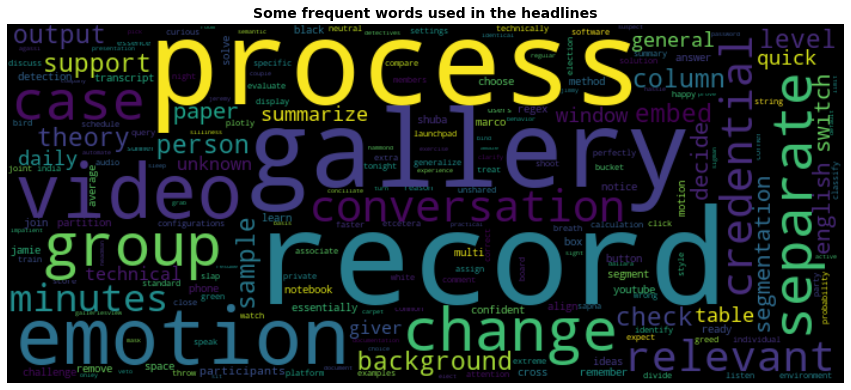

Summary results from sentence score based on word frequency
[so because i'm not using the multi processing so far, but i guess the multi processing should be the same result., but i'm afraid that we get into the trouble that i had with the image processing method that even if we had, even if we had and a great thing we're using image of pressing that can generalize on both joint and joined videos., is he actually shows his meeting in gallery view where nobody the gallery., if we see a gallery view recording, then we'll know my theory work., because what i feel these emotion prediction models the have extreme emotion., so they just had a call over the armor in the sapna on, but the amador, like simon is we have toe want to calculate the relevant worlds off the particular speaker that the one person is saying in this kind of conversation., so, like the like, they want to compare the relevant words with the give with the givers, how much the conversation is relevant and how much is not li

/opt/anaconda3/lib/python3.7/site-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


Summarize Text from cosine similarity of sentences: 
 um what if we perhaps average? aren't the best metric. theater dictionary in which i have all the that are being predicted. perhaps there's some threshold for out liars thinking of it as kind. beat out. yours just l.s.t.m. where we could use that technical, but it's also like dick. where is he? so in some are you can use. were spent time tomorrow to look at that. vocabulary like i'm great. victorian model, so i'm just using the library from this. unique those have. this a classic growth him in the halftime and and maybe less than half time. the way he handled those. the pirate transition was as are on this find out. the ice are to see how, um just to look at how to align. special. so i'm really scared to get into something. so cranky, like there is some overlapping. so alright, guys. shays is kind off. sector. pretty consistently. off the her a period of time. maybe you and south now will be working with me on it. maybe see how were

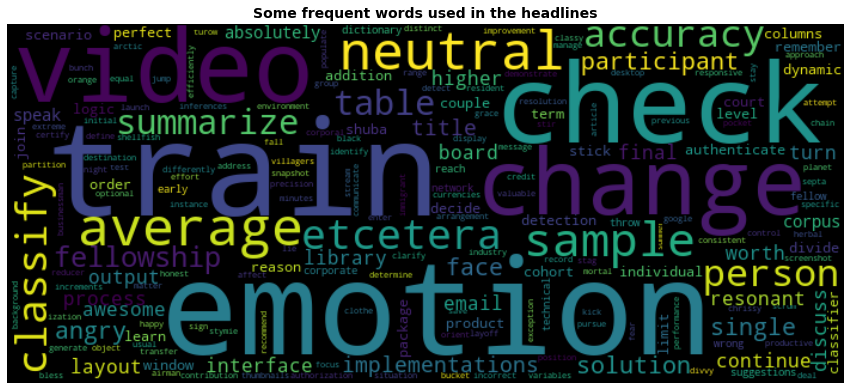

Summary results from sentence score based on word frequency
[, it might be worth our effort, um, to take a look at at what it would take to, you know, to, you know, for, you know, to to use that the state of our solution is it, you know, is there, you know, is it some transfer learning where we need to go out and grab, grab and and label a bunch of data, you know, etcetera, etcetera, those sort of things., um, i'll need to write an interface that takes that detail information, summarizes it and then populates a system called air table and air table is the system that shuba and our shik used that provides the summarized information on each of the fellows., is for detecting the faces, and the other is a classifier that classifies emotion., classify morgan's for for your training of emotion, classified and now., um, that you could go higher because we be more interested in, you know, like they were neutral, you know, they turned angry, , you know, we will suggest some standards, but if it

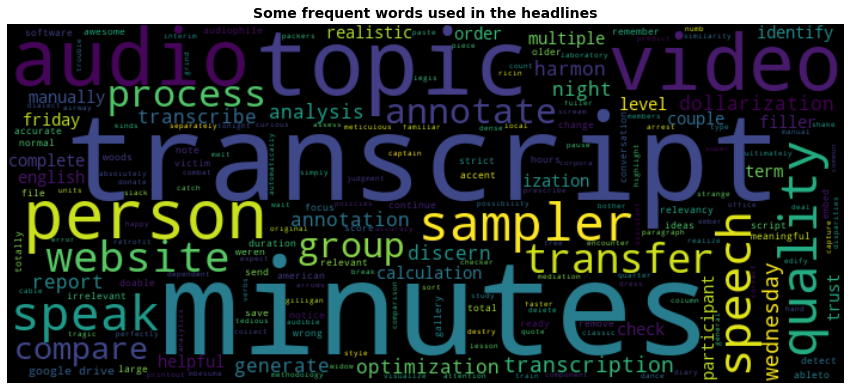

Summary results from sentence score based on word frequency
[as of right now, if we if we already, like, kind of lift our fingers up from our computers and see what we hade we have about maybe 35 minutes of speech dollarization, 25 minutes of 50 minutes of auto sampler on what will be like, you know, 15 or 20 minutes of website., so i think if we all target saying, like, let's get 40 minutes her meeting 45 minutes., um so hypothetically, if you finish that website video on, then did another like 20 minutes of the m better video., um, and then each person for whatever called they do that just transcribe or annotate 22 minutes of it, and that's it., the next thing is like maybe if we're just doing topic modeling, and i think harmon something you can speak to this if instead of giving the dye arised audio in if we just pass in the entire audiophile into s are and then use that for topic modeling without splitting it up., even in 34 minutes of audio, you have, like, a couple 100 words., so

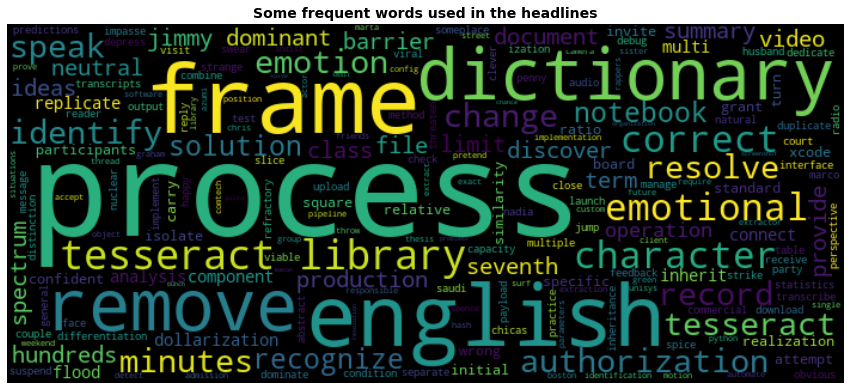

Summary results from sentence score based on word frequency
[but the tesseract library does not recognize it is an english word, so it's it's returning now, so i need to mess., and the boston process function is, um is there any any any function or any operation with you we want to make on their returns from the along the multi processing processes., you know what i talked about, um, tesseract high test track being being language specific, um, like it would not be ocr library., functions are flooding the process, and but what's the process?, but one thing that we discovered it is the the tesseract ocr library, there's a lot of parameters to the two that tesseract ocr library., the process is that the actual function, we will be, well, we would be doing in each of process., yes, just just just take a look at the tesseract library and and that's not available within their., it's more than the tesseract library]


Summarize Text from cosine similarity of sentences: 
 you met utterance so 

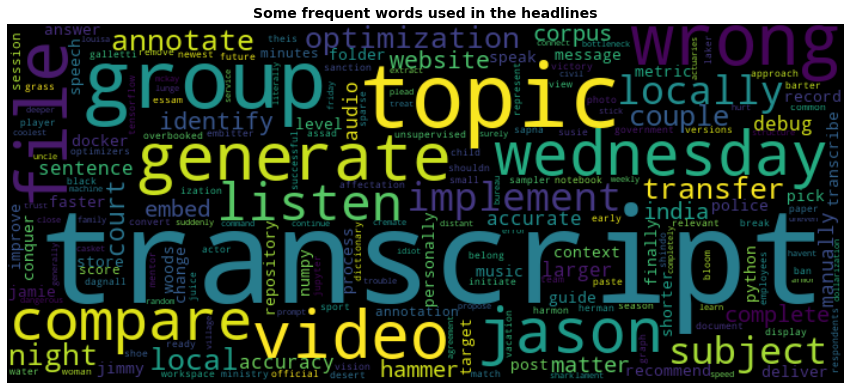

Summary results from sentence score based on word frequency
[i tried to identify the for the show like this transcript belongs to them by their group and display this transcript long toe, bean that transcripts and the transcripts that meetings., yes, it's like for some embedded looks for someone sometimes though another good subject optimization or for the other group that how how is the structure of the jason file mandy like, is it for a one completely that distant files for one complete day?, it will store the casket also on over local system, so it will store the transcript in your local computer., the like the unsupervised earlier with the transcripts that i have on but like first of the first goal is to identify the topics related., the transcripts that i have on beings done that laker have generated topic., and i'm running locally back, like on the friday was able to generate the one transcript., i i was planning to wrong for as many transcripts, but the transcript optimization b

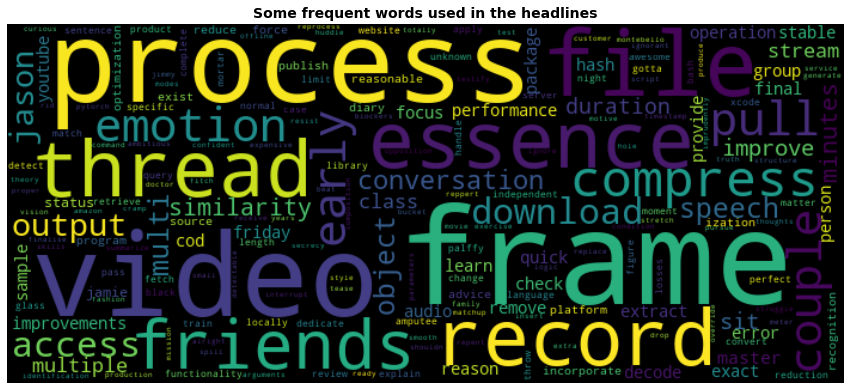

Summary results from sentence score based on word frequency
[no, i'm probably, uh uh, and i actually did some small improvements that also, in improving, improving, improving xcode, for example, i found that sitting in the sitting operation and getting that we used to get the friend time timestamp and for sitting that you use, um that didn't was actually sitting, but we used we used the reading, which should fish the frames., i was reading about threading and how to make reading, uh, reading frames., yeah, that reading of operation is very expensive because it actually decodes the codes three frames and we only use, like, one or two friends from each second, because in essence, your air sampling one frame and how much of value one frame., that's because i looked at the current video interesting with which is like around 11 hour and 10 minutes or stuff on the dental care for two friends toe, because we have, like, 25 to 30 frame in average were for normal videos, and we are like taking 

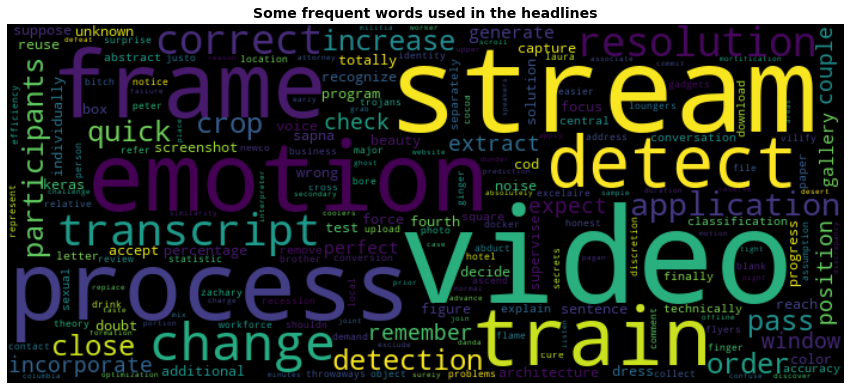

Summary results from sentence score based on word frequency
[the the whole picture frame and the cropping without pre processing and the waste problem with pre passing at the fungal cropping works very well because it's ah,, yeah, like i was cashing because off on the speaker, you and we can kind of some logic when we do emotion detection, because those done to emotions on every frame we do, it's like, gravelly., i only need to use one video stream, so explain why you would need the well., the video video view we do is arm on., and so when we do emotions, we just grab from another video frames., so that the review a new video we have because i mean, being uploaded on the the resolution was very local., so the only difference is so once we get to the point where cv where open sea v.s. processing rather than passing through the the path e stream, we just pass in the the constructor will take take a path and a file name as well., rather than passing in a passing in the path e stream, i'm 

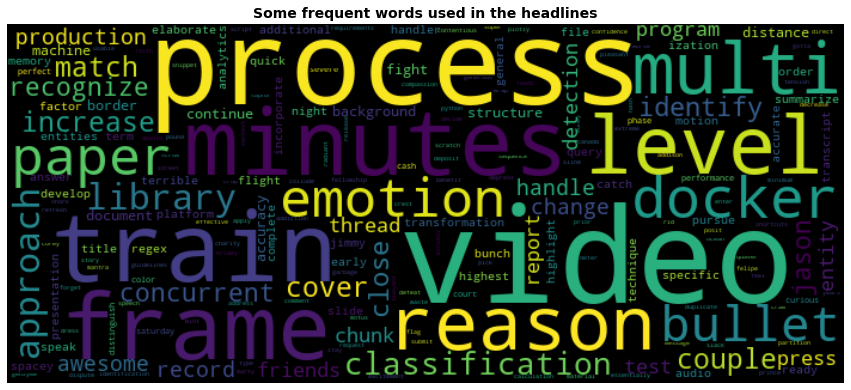

Summary results from sentence score based on word frequency
[the video faith video frames., okay, now, for i realized that when i think part of the video is just a screen sharing thing, we m.l. cashing and multi processing, you just say no video video since., no, let me just add video video., i've mentioned it in this slide started video, so for its are just finalized., maybe if we process it for the complete video or i'm who pulled that is accurate., it was based off of, you know, frames, video frame.  , so to deter, mined whether we see a name what name on programs or it is video are extreme sharing., i see you sent me asking about, um i wanted to start working on, you know, the video portion of emotion detection., first for training, training, new entities training., kind of where video motion detection is., that is, um we got the hashing, and we've got concurrent processing at the highest level., presses processing talk 20 minutes on this machine,, ah, weekend, justin, just to skip

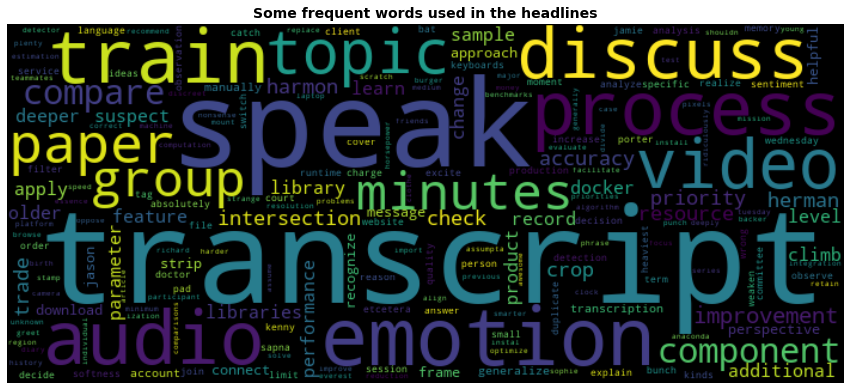

Summary results from sentence score based on word frequency
[, i needed to align the sampling rate of, um, that we're getting out of, um uh, you know, out of the new o. c. the new performance process with the the sampling rate that we're doing on the audio because if we're not in sync, obviously, you know, when we replace an unknown we you know, it's it's, so check emotion detection works on small images, and if it does great works, there is no point in, you know, trying toe increase number improve number., a video first priority audio, second priority., so rather than connecting to it at all, if the jason actually just stores data about the audio file, then we can just navigate that link and download it rather than having to, um, parse through and then connect to the meeting ideal., but you guys, i like the fact that you guys are thinking and and kind of yuri's absar observation and comment that, you know, like like on the images first, will will use the, you know, the images as they 

In [8]:
# reading all documents
combined_words = ""
doc_wise_combined_words = []
docs = []
i=0
for transcript_file_name in glob.iglob('./transcripts/train//*.*', recursive=True):
    print("\n")
    print(os.path.basename(transcript_file_name))
    data = open(transcript_file_name).readlines()
    speaker_data = {line.split(":")[0]:line.split(":")[1] for line in data}
    words_in_file = ""
    speaker_dic ={}
    for name,words in  speaker_data.items():
        words = words.replace("\n","").lower()
        words_in_file = words_in_file + words
        if name.split("_")[0] in speaker_dic:
            speaker_dic[name.split("_")[0]] += words
        else:
            speaker_dic[name.split("_")[0]] = words
    print("Words:",str(len(words_in_file)))
    i+=1
    combined_words += words_in_file
    doc_wise_combined_words.append(words_in_file)
    print(collections.Counter(preprocess(words_in_file)).most_common(10))  # most common top 10 words
    print("\nLDA Results*********************")
    print_lda_bow_result([[words_in_file]],3)                              # lda result
    get_word_cloud(words_in_file)                                          # printing word cloud
    print("Summary results from sentence score based on word frequency")
    print(get_spacy_summary(words_in_file,0.02))                           # printing spacy summary
    print("\n")
    get_cosine_sentence_similarity_summary(words_in_file,50)               # printing sentence cosine similarity summary
    docs.append([words_in_file])
print ( "Total Transcripts : ",str(i))
cleaned_docs = []
for doc in docs:
    for word in doc:
        cd = preprocess(word)
        cleaned_docs.append(cd)
        